In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset,date2num, num2date
import os
import netCDF4
import cartopy.crs as ccrs
from scipy.stats import linregress
from scipy.stats import ttest_ind
from sklearn.linear_model import QuantileRegressor, Ridge
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
%matplotlib inline

import statsmodels.api as sm
import statsmodels as sm

In [2]:
import sys

HOME = '/scistor/ivm/the410'
sys.path.append(f'{HOME}/CirculationTrends_Happe2025JCLi/')

from GolfVijf.thresholding import *
from GolfVijf.utils import plot_trends_per_gridpoint, onelag_cov, covariance_timeseries, xr_linregress, trendfit_robust, data_for_pcolormesh, covariance_timeseries2
from GolfVijf.processing import load_and_subset_data, compute_trend_pattern, remove_spatmean_variability, spatial_subset, subdomains
#from Tamara_notebooks.data_loading import * 
#from Tamara_notebooks.DDdays_processing import create_event_length_per_year

In [3]:
from compositing import *

# Load T2M data, Land Sea Mask, GMST, and Covariance timeseries

In [4]:
path_data='/scistor/ivm/the410/WAVE5'

In [5]:
t2m_jja = load_and_subset_data(variable = "T2M", months = [6,7,8], 
                               subdomain = 'midlat', ndays = 1).astype("float32") - 273.15

In [15]:
lsm = xr.open_dataset(f"{path_data}/ERA5_land_sea_mask_0.25deg_midlats.nc")['lsm'].sel(
    time='1950-01-01T00:00:00.000000000')
## 1 where land

<Axes: xlabel='Year'>

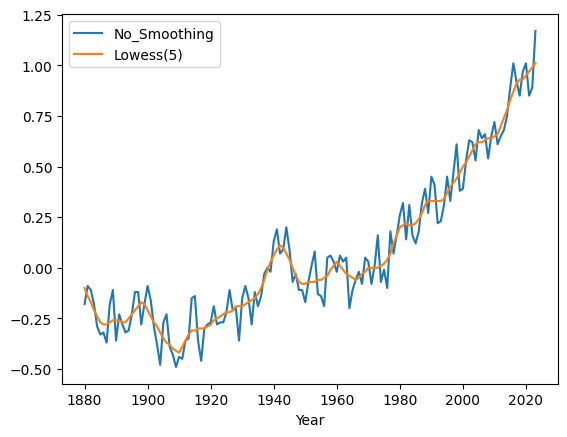

In [8]:
#GMST 

yearly_GMST = pd.read_csv(f"{path_data}/NASA_GMST.csv", delimiter=";", skiprows=1, index_col=0)
yearly_GMST.plot()

In [9]:
###GMST###
ny = 2023 - 1940 + 1 
LOWESS5y_yearly_GMST = yearly_GMST["Lowess(5)"][-ny:].to_numpy() ## select correct timeperiod
GMST_reshaped = np.empty(92*ny,) #empty array with shape of number of days (e.g 92 per summer, per year)
for i, GMST in enumerate(LOWESS5y_yearly_GMST): ## loop over the GMST data to fill the array
    year_array = np.array(92 * [GMST], dtype=float)
    GMST_reshaped[i*92:(i+1)*92] = year_array[:]
#create xarray 
GMST_xr = xr.DataArray(
    data=GMST_reshaped,
    dims=["time"],
    coords=dict(
        time=t2m_jja.time.dt.year,),
    attrs=dict(
        description="Global Mean Surface Temperature anomalie from NASA, 5 year LOWESS",
        units="degC",),)

/scistor/ivm/the410/test_tensorflow3/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


###### standardizing GMST (x1)

In [10]:
## GMST
GMST_x1 = (GMST_xr - GMST_xr.mean()) / GMST_xr.std()

#### Now get the covariance timeseries of US_Atl and Eurasia

In [11]:
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"

In [12]:
import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

In [13]:
daJJA_1979_2023 = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=1979)
daJJA_1979_2023.attrs["units"]=unit

daJJA_1979_None_trend = compute_trend_pattern(daJJA_1979_2023)

In [86]:
region = "US_Atl"

In [87]:
covars_daily = aggregated_covars_region(region=region, data=daJJA_removed_seasonality,
                                        trend_pattern=daJJA_1979_None_trend, 
                                        time_aggr='daily')

US_Atl
(35, 70, -100, 0)


Text(0.5, 1.0, 'Daily covars for US_Atl')

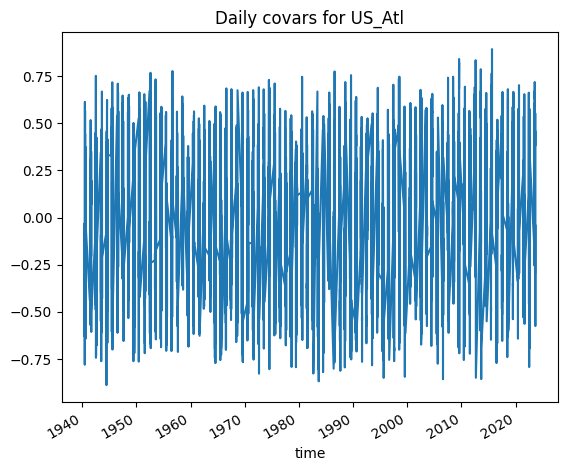

In [88]:
covars_daily.plot()
plt.title(f"Daily covars for {region}")

## combine the two X values & predict temperature [time, features]

In [89]:
X_combined = np.empty((covars_daily.shape[0], 2))
X_combined[:,0] = GMST_x1[:]
X_combined[:,1] = covars_daily[:]
X_combined[:10,:] 

array([[-0.67973312, -0.29970106],
       [-0.67973312, -0.33127108],
       [-0.67973312, -0.51235819],
       [-0.67973312, -0.62900364],
       [-0.67973312, -0.52084523],
       [-0.67973312, -0.46844706],
       [-0.67973312, -0.50049686],
       [-0.67973312, -0.52088124],
       [-0.67973312, -0.43565235],
       [-0.67973312, -0.25136012]])

In [90]:
##### Predict T2M from Covars and GMST, save the ouput

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score


t2m_std = t2m_jja.std(dim="time")
t2m_mean = t2m_jja.mean(dim="time")


coefs = np.empty((141, 1440, 2)) #shape of t2m and nr of features
R2 = np.empty((141, 1440)) #shape of t2m and nr of features
T2M_dynamical = np.empty((t2m_jja.shape[0], 141, 1440)) #shape of t2m 
T2M_GMST = np.empty((t2m_jja.shape[0], 141, 1440)) #shape of t2m 
T2M_predicted = np.empty((t2m_jja.shape[0], 141, 1440)) #shape of t2m 
T2M_dynamical_std = np.empty((t2m_jja.shape[0], 141, 1440)) #shape of t2m 
T2M_GMST_std = np.empty((t2m_jja.shape[0], 141, 1440)) #shape of t2m 


for i, lat in enumerate(t2m_jja.latitude):
    for j, lon in enumerate(t2m_jja.longitude):
#         print(int(lat), int(lon))
        Y = t2m_jja.sel(latitude=lat, longitude=lon).values.reshape(t2m_jja.shape[0])
        Y = (Y - t2m_mean[i,j].values) / t2m_std[i,j].values #standardize
#         if lsm[i,j] == 1. : 
        if lsm[i,j] >= 0.90 :
            #print("land point so continue")
            LRModel = LinearRegression(fit_intercept=False)
            LRModel.fit(X_combined, Y)
            coefs[i,j,:]=LRModel.coef_
    
            ##predict and save R2score 
            Y_pred = LRModel.predict(X_combined).reshape(-1,1)
            R2[i,j] = LRModel.score(X_combined, Y)

            T2M_predicted[:,i,j]=Y_pred[:,0]

            ## predict t2m_from dynamics only
            t2m_due_to_dynamics_std = LRModel.coef_[1] * X_combined[:, 1]
            T2M_dynamical_std[:,i,j] = t2m_due_to_dynamics_std
            t2m_due_to_dynamics = t2m_due_to_dynamics_std * t2m_std[i,j].values  + t2m_mean[i,j].values
            T2M_dynamical[:,i,j]= t2m_due_to_dynamics[:]
            
            ## predict t2m_from GMST only
            t2m_due_to_GMST_std = LRModel.coef_[0] * X_combined[:, 0]
            T2M_GMST_std[:,i,j] = t2m_due_to_GMST_std
            t2m_due_to_GMST = t2m_due_to_GMST_std * t2m_std[i,j].values  + t2m_mean[i,j].values
            T2M_GMST[:,i,j]= t2m_due_to_GMST[:]
            
            
        else:
            ## masked point
            coefs[i,j,:] = np.array([np.NaN,np.NaN])
            R2[i,j] = np.NaN
            T2M_dynamical[:,i,j]= np.array([np.NaN]* X_combined.shape[0])
            


## to save the data

In [92]:
T2M_dynamical_xr = xr.DataArray(
    data=T2M_dynamical,
    dims=["time", "latitude", "longitude"],
    coords=dict(
        time=t2m_jja.time.values,
        latitude=t2m_jja.latitude.values,
        longitude=t2m_jja.longitude.values,),
    attrs=dict(
        description=f"T2M due to covariance pattern on trend pattern of {region}",
        units="degC",),)

T2M_GMST_xr = xr.DataArray(
    data=T2M_GMST,
    dims=["time", "latitude", "longitude"],
    coords=dict(
        time=t2m_jja.time.values,
        latitude=t2m_jja.latitude.values,
        longitude=t2m_jja.longitude.values,),
    attrs=dict(
        description=f"T2M due to GMST on trend pattern of {region}",
        units="degC",),)

R2_xr = xr.DataArray(
    data=R2,
    dims=["latitude", "longitude"],
    coords=dict(
        latitude=t2m_jja.latitude.values,
        longitude=t2m_jja.longitude.values,),
    attrs=dict(
        description=f"R2 for lin model to predict t2m from GSMT and covariance pattern on trend pattern of {region}",
        units="",),)


# Loading in the data 

In [6]:
region="EURASIA"

In [7]:
T2M_dynamical_xr = xr.open_dataset(f"{path_data}/T2M_attribution/{region}_t2m_dynamical.nc")["__xarray_dataarray_variable__"]
T2M_dynamical_xr.attrs = {"units":"degrC"}

T2M_GMST_xr = xr.open_dataset(f"{path_data}/T2M_attribution/{region}_t2m_gmst.nc")["__xarray_dataarray_variable__"]
T2M_GMST_xr.attrs = {"units":"degrC"}

R2_xr = xr.open_dataset (f"{path_data}/T2M_attribution/{region}_r2.nc")["__xarray_dataarray_variable__"]
coef_xr = xr.open_dataset(f"{path_data}/T2M_attribution/{region}_coeffs.nc")["__xarray_dataarray_variable__"]

## Make figures

In [8]:
T2M_dynamical_trend = compute_trend_pattern(T2M_dynamical_xr)

/scistor/ivm/the410/CirculationTrends_Happe2025JCLi/GolfVijf/utils.py:32: UserWarning: Too little samples found. Minimum: 30
  warnings.warn(f'Too little samples found. Minimum: {min_count}')


In [9]:
T2M_GMST_trend = compute_trend_pattern(T2M_GMST_xr)

In [10]:
t2m_jja.attrs = {"units":"degrC"}
t2m_jja_all_trend = compute_trend_pattern(t2m_jja)

Plot below

In [11]:
# Determining locations and consistent color coding
sf_extreme_locs =[(58,-150),(42,-125),(41,-86),(56,-60),(52,-20),(47,3),(52,30),(39.5,65),(45,100),(38,177)] # lat, lon

subdomains_ = {
             'circumglobal': (35,70,-180,180),
        'Both': (35,70,-100,110),
'US_Atl':(35,70,-100,0),
        'EURASIA': (35,70,15,110)}

colors_dict  = {'US_Atl':'lawngreen',
        'EURASIA': 'yellow',
             'Both': 'blue',
             'circumglobal': 'black'}

region_name_dict = {"US_Atl":"US Atlantic", 
                   "EURASIA": "Eurasia"}

## plotting Total T2M trend, with land sea mask

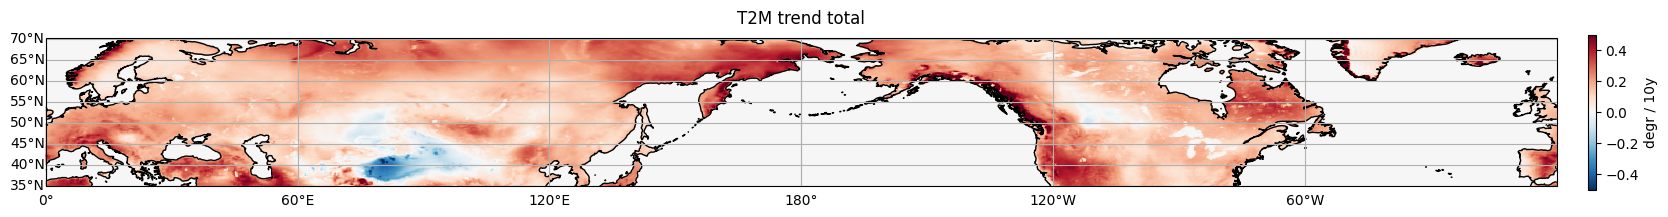

In [16]:
data = t2m_jja_all_trend * 10 * lsm
title=f"T2M trend total"

vmin, vmax = -0.5, 0.5
unit="degr / 10y"

######
shading = 'nearest'

cmap = 'RdBu_r'
fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
im = ax.pcolormesh(data.longitude, data.latitude, data[:,:], transform = ccrs.PlateCarree(),
                        shading = shading, cmap = cmap, vmin=vmin, vmax=vmax)

ax.coastlines()
ax.set_title(title)
ax.gridlines(draw_labels = ['left','bottom'])
fig.colorbar(im, ax=ax, fraction=0.005, pad=0.02, label=f"{unit}")
plt.show()



## plotting the relative trend, masking very low values

In [17]:
t2m_jja_all_trend_masked = np.where(t2m_jja_all_trend < 0.0000001, np.nan, t2m_jja_all_trend)

In [18]:
#masked very small trends
T2M_dynamical_trend_perc_of_all = (T2M_dynamical_trend / t2m_jja_all_trend_masked) * 100
T2M_GMST_trend_perc_of_all = (T2M_GMST_trend / t2m_jja_all_trend_masked) * 100

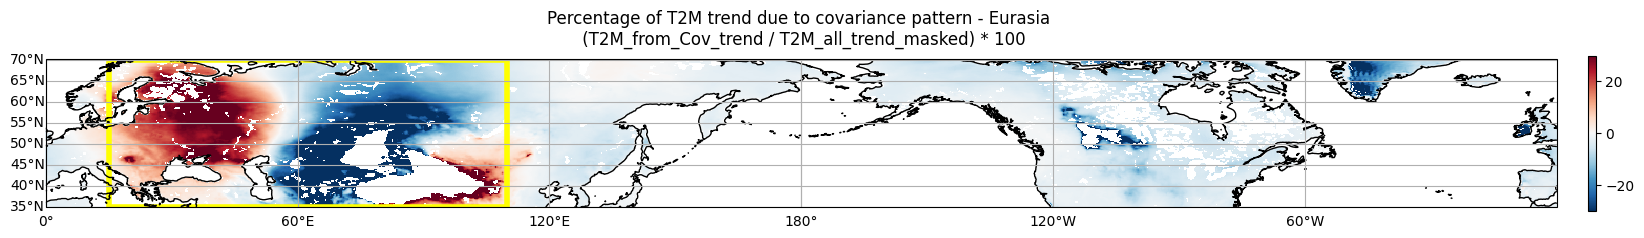

In [20]:
data = T2M_dynamical_trend_perc_of_all
title=f"Percentage of T2M trend due to covariance pattern - {region_name_dict[region]} \n (T2M_from_Cov_trend / T2M_all_trend_masked) * 100"

# vmin, vmax = -0.1, 0.1
unit=""

######
shading = 'nearest'

cmap = 'RdBu_r'
fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
im = ax.pcolormesh(data.longitude, data.latitude, data[:,:], transform = ccrs.PlateCarree(),
                        shading = shading, cmap = cmap, vmin=-30, vmax=30)

coords = subdomains[region]
color=colors_dict[region]
ax.add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                facecolor='none', edgecolor=color, linewidth=4,
                                transform=ccrs.PlateCarree()))

ax.coastlines()
ax.set_title(title)
ax.gridlines(draw_labels = ['left','bottom'])
fig.colorbar(im, ax=ax, fraction=0.005, pad=0.02, label=f"{unit}")
plt.show()



And for US Atlantic:

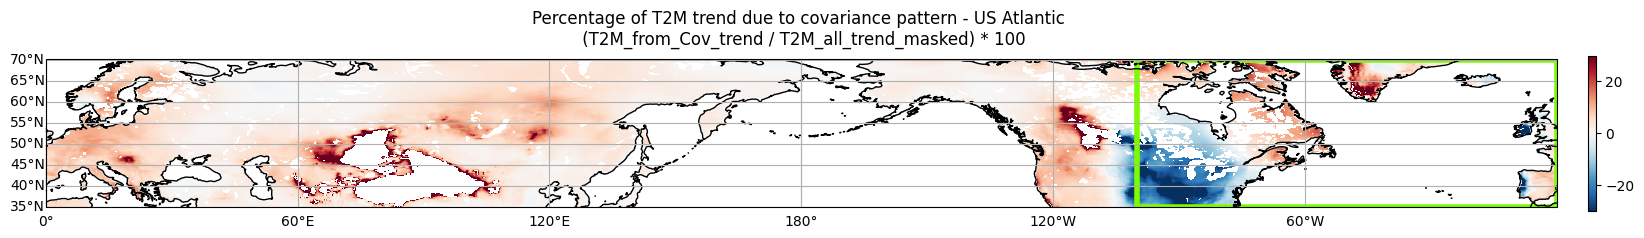

## Plotting Figure B7

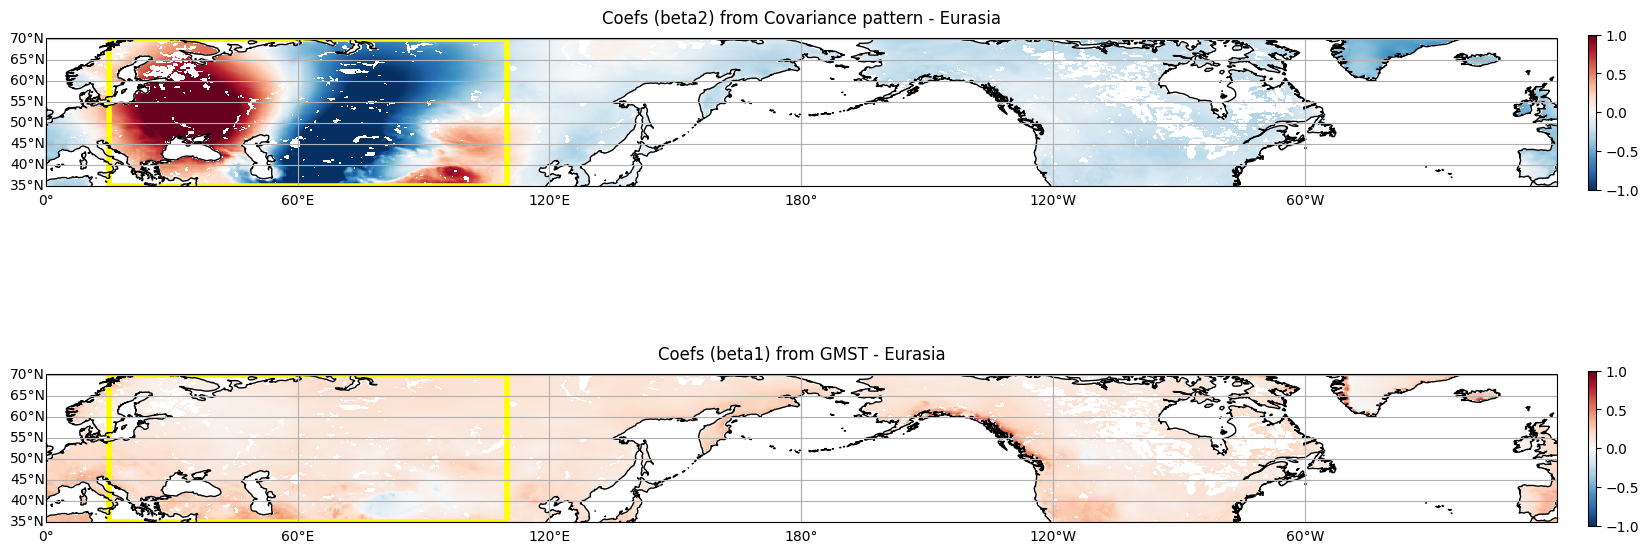

In [23]:
data = coef_xr
# title=f"Coefs from model - {region_name_dict[region]}"

vmin, vmax = -1, 1
unit=""

######
shading = 'nearest'

cmap = 'RdBu_r'
fig, ax = plt.subplots(2,1, figsize = (20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

im = ax[0].pcolormesh(t2m_jja.longitude, t2m_jja.latitude, data[:,:, 1], transform = ccrs.PlateCarree(),
                        shading = shading, cmap = cmap, vmin=vmin, vmax=vmax)
ax[0].coastlines()
ax[0].set_title(f"Coefs (beta2) from Covariance pattern - {region_name_dict[region]}")
ax[0].gridlines(draw_labels = ['left','bottom'])
fig.colorbar(im, ax=ax[0], fraction=0.005, pad=0.02, label=f"{unit}")

im = ax[1].pcolormesh(t2m_jja.longitude, t2m_jja.latitude, data[:,:, 0], transform = ccrs.PlateCarree(),
                        shading = shading, cmap = cmap, vmin=vmin, vmax=vmax)

ax[1].coastlines()
ax[1].set_title(f"Coefs (beta1) from GMST - {region_name_dict[region]}")
ax[1].gridlines(draw_labels = ['left','bottom'])
fig.colorbar(im, ax=ax[1], fraction=0.005, pad=0.02, label=f"{unit}")


coords = subdomains[region]
color=colors_dict[region]

ax[0].add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                facecolor='none', edgecolor=color, linewidth=4,
                                transform=ccrs.PlateCarree()))
ax[1].add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                facecolor='none', edgecolor=color, linewidth=4,
                                transform=ccrs.PlateCarree()))




plt.show()

